# Nearest Neighbor classification in detail
We already saw how to use the nearest neighbors classifier that is provided by scikit-learn. In this lab we will implement the algorithm ourselves to get a better understanding of it's inner workings.

In practice, you are likely to make use of existing implementations for most modeling work. However, it can be helpful to look behind the curtains and see that the algorithms are not necessarily complicated black boxes, but that you could implement them yourself as well.

We will also look at the influence of the hyper parameters in the nearest neighbors model, the number of neighbors to consider, in this lab.

## Toy dataset
We are starting with a two-dimensional toy dataset, that is a dataset with two features. Looking at datasets with two feature can be helpful for illustration purposes as we can visualize the data using a scatter plot.

In [1]:
from sklearn.datasets import make_moons
X, y = make_moons(noise=.3, random_state=0)

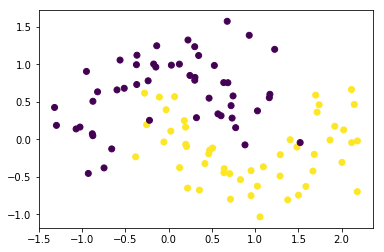

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.scatter(X[:, 0], X[:, 1], c=y)

### Task
Start by splitting the data into a training and a test set.
We will start by creating a "one nearest neighbor" model that only takes the one nearest neighbor into account.

Compute the euclidean distances from all data points in the test data to all the data points in the training data in a numpy array. You can either compute the distances directly with numpy, use the ``sklearn.metrics.pairwise`` module, or use ``scipy.spatial``.

In [24]:
from sklearn.model_selection import train_test_split
import scipy.spatial as sps

X_train, X_test, y_train, y_test = train_test_split(
   X, y, random_state=0)
print(X_train.shape)
print(X_test.shape)
# compute distances here
outer = []
for i in X_test:
    inner = []
    for j in X_train:
        inner.append(sps.distance.euclidean(i,j))
    outer.append(inner)
    
# distances = ...
distances = outer


(75, 2)
(25, 2)


Next, compute the index of the closest point in the training data using ``np.argmin``:

In [29]:
import numpy as np

# closest_for_each_test_point = np.argmin(...)
argmins = []
for i in distances:
    argmins.append(np.argmin(i))
print(argmins)

[1, 40, 47, 56, 70, 62, 61, 29, 56, 54, 51, 21, 18, 52, 59, 44, 5, 55, 67, 26, 0, 67, 40, 25, 58]


Finally, compute the predictions ``y_pred`` made by the model, by assigning to each test point the label of the closest training point in ``y_train``:

In [32]:
# y_pred = ...
y_pred = []
for i in argmins:
    y_pred.append(y_train[i])
print(y_pred)

[0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]


Now we can compute the accuracy of our predictions:

In [33]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.95999999999999996

Now compare the predictions made by your code with the predictions made by ``KNeighbors`` with ``n_neighbors=1``. They should be identical

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=1)

knc.fit(X_train,y_train)
knc.score(X_test,y_test)

0.95999999999999996

Now, extend your code to take multiple neighbors into account. You can use ``np.argsort`` to find the ``k`` nearest neighbors (say 5) from the distances. Fetch the label associated with all 5 neighbors, and compute the most common label among them.

In [65]:
# code here...
print(np.array(distances).shape)

sortedargs = []
n_neigh = 5
for i in distances:
    sortedargs.append(np.argsort(i)[:n_neigh])
#print(sortedargs)

it = 0
y_pred_long = []
for i in sortedargs:
    y_pred_list = []
    for j in i:
        y_pred_list.append(y_train[j])
    y_pred_long.append(y_pred_list)
                       
print(y_pred_long)
y_pred = []
for i in y_pred_long:
    if sum(i)<n_neigh/2:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(y_pred)
accuracy_score(y_test, y_pred)

(25, 75)
[[0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0], [1, 1, 0, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [1, 0, 0, 1, 1], [1, 1, 1, 1, 1], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 1, 1, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [1, 1, 1, 1, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]


0.92000000000000004

Compare your results again with those obtained using ``KNeighborsClassifier``, this time with ``n_neighbors=5``. Again they should be identical.

# Influence of n_neighbors in KNeighborsClassifier
Next, let's study how changing the number of neighbors to consider changes the predictions. One way to inspect a model is to look at the **decision boundaries**, which is the boundaries in the input space between data that is classifed as one class and data that is classified as another class.
As our data only has two features, we can easily visualize these boundaries in the input space. The following function can help you with that.

In [ ]:
def plot_2d_classification(classifier, X):                                       
                                                                                                            
    eps = X.std() / 2.                                                                                                       
    ax = plt.gca()                                                                                                           
    
    # create a dense grid of values to evaluate the classifier
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps                                                                      
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps                                                                      
    xx = np.linspace(x_min, x_max, 1000)                                                                                         
    yy = np.linspace(y_min, y_max, 1000)                                                                                         
    X1, X2 = np.meshgrid(xx, yy)                                                                                                 
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    # evaluate the classifier on the grid
    decision_values = classifier.predict(X_grid)
    # show the classification results:
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,                                                           
                                                       y_min, y_max),                                                          
            aspect='auto', origin='lower', alpha=alpha)                                                               
    ax.set_xlim(x_min, x_max)                                                                                                    
    ax.set_ylim(y_min, y_max)             

### Task
Use the ``plot_2_classification`` function to plot the decision boundary for the toy data we used above for ``KNeighborsClassifier`` with different values of ``n_neighbors``. What do you notice?
For each value of ``n_neighbors`` you try, also record training set accuracy and test set accuracy.

In [1]:
# code here